# 0. Importing packages

In [7]:
print("Importing packages")
# import pandas as pd
# import numpy as np
# import uproot
# import awkward as ak
# import glob
import random
from scipy.optimize import *
import pickle
import time
from matplotlib import pyplot as plt
from packages.readData import *
from packages.thresholdFns import *

Importing packages


# 1. Loading data

In [ ]:
def prepareInputs(dir, subset=1, cuts=(0, 0), flatten=False, subtractMuon=True, oldData=False):

    if oldData = False:# Read in offline and online data
        data = dir + ":Events;1"
        calo = readCaloData(data = data)
        oMET = readPuppiData(data = data, subtractMu = subtractMuon)
    else:
        data = dir
        calo = readCaloDataOld(data = data)
        oMET = readPuppiDataOld(data = data)

    # Cut MET online and offline based on cuts argument
    if (cuts[0] != 0) and (cuts[1] != 0):
        calo, oMET = cutMET(cuts = cuts, calo = calo, oMET = oMET)

    # Flatten MET distribution at low MET to increase emphasis on higher MET region
    if flatten != False:
        calo, oMET = flattenMET(calo = calo, oMET = oMET, flat_params = flatten)

    # Subset events into fitting and testing samples
    fit_events, valid_events = subsetEvents(calo=calo, oMET=oMET, subset=subset)
    
    # Calculate NTT4
    print("Calculating NTT4")
    fit_calo_events, valid_calo_events = fit_events[0], valid_events[0]
    compntt_fit, compntt_valid = compNTT4(fit_calo_events), compNTT4(valid_calo_events)

    # Package and return data
    fit_data = (fit_events[0], fit_events[1], compntt_fit)
    valid_data = (valid_events[0], valid_events[1], compntt_valid)
    
    return fit_data, valid_data

In [94]:
data2024 = "/shared/scratch/wq22321/data/NANOAOD_Muon0Run2023D_ZMu_PromptReco_v2RAW_RECO_2023_v0_4/231121_100830/0000/out_*.root:Events;1"
puppi = readPuppiData(data=data2024)

Reading in PUPPI MET pT and phi
Calculating x and y components of PUPPI MET
Reading in muon pT and phi
Calculating muon ptx and pty for each event
Calculating PUPPI MET no Mu and reformatting data


/users/wq22321/methackathon_2024/packages/readData.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfcand_muons['muon_ptx'] = np.cos(pfcand_muons['Muon_phi']) * pfcand_muons['Muon_pt']
/users/wq22321/methackathon_2024/packages/readData.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfcand_muons['muon_pty'] = np.sin(pfcand_muons['Muon_phi']) * pfcand_muons['Muon_pt']


In [86]:
calo = readCaloData(data=data2024)

Reading in calo tower data


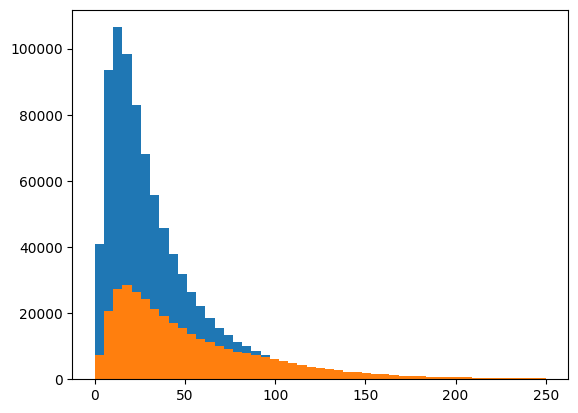

In [95]:
cutoff = 500
a = 0.94
b = 0.066
c = 0.04

rand_arr = np.random.rand(len(puppi))
puppi_pt = puppi['puppi_MetNoMu']

# for a in np.linspace(0.8, 1., 11):
#     puppiflat = puppi[rand_arr * (a - puppi_pt**b / cutoff**b) < c]     # rand arr gives each event a probability to be included
#     plt.hist(puppi.puppi_MetNoMu, bins=bins)
#     plt.hist(puppiflat.puppi_MetNoMu, bins=bins)
#     print("a = {}".format(a))
#     plt.show()

# for b in np.linspace(0.05, 0.07, 11):
#     puppiflat = puppi[rand_arr * (a - puppi_pt**b / cutoff**b) < c]     # rand arr gives each event a probability to be included
#     plt.hist(puppi.puppi_MetNoMu, bins=bins)
#     plt.hist(puppiflat.puppi_MetNoMu, bins=bins)
#     print("b = {}".format(b))
#     plt.show()

# for c in np.linspace(0.0, 0.1, 11):
#     puppiflat = puppi[rand_arr * (a - puppi_pt**b / cutoff**b) < c]     # rand arr gives each event a probability to be included
#     plt.hist(puppi.puppi_MetNoMu, bins=bins)
#     plt.hist(puppiflat.puppi_MetNoMu, bins=bins)
#     print("c = {}".format(c))
#     plt.show()

# for cutoff in np.linspace(0, 1000, 11):
#     puppiflat = puppi[rand_arr * (a - puppi_pt**b / cutoff**b) < c]     # rand arr gives each event a probability to be included
#     plt.hist(puppi.puppi_MetNoMu, bins=bins)
#     plt.hist(puppiflat.puppi_MetNoMu, bins=bins)
#     print("cutoff = {}".format(cutoff))
#     plt.show()

#caloflat = calo[rand_arr[puppi_pt > 0] * (a - puppi_pt**b / cutoff**b) < c]
puppiflat = puppi[rand_arr[puppi_pt > 0] * (a - puppi_pt**b / cutoff**b) < c]
bins=np.linspace(0,250,50)
plt.hist(puppi.puppi_MetNoMu, bins=bins)
plt.hist(puppiflat.puppi_MetNoMu, bins=bins)  
plt.show()


# 4. Optimisation

In [ ]:
print("Loading data")
data = "/shared/scratch/wq22321/zmu_2023_data/*.root"
fitOld, validOld = prepareInputsOld(dir = data, subset=0.7, cuts=(0, 250), prop = 0.75)

In [ ]:
caloOld, puppiOld, ntt4Old = fitOld

In [ ]:
def objective(params, turn_on = False):
    a, b, c, d = params
    print("\nCurrently trying: a = {}, b = {}, c = {} and d = {}".format(np.round(a,2), np.round(b,2), np.round(c,2), np.round(d,2)))
    MET, _ = applyCaloTowerThresh(calo, a, b, c, d)
    
    if turn_on == True:
        offline_bins = np.linspace(0, 300, 60)
        eff_0p05 = 0
        foundEff0p05 = False
        eff_0p95 = 99999
        eff_before = 0
        x_cross_95 = 99999
        x_cross_05 = 0
        eff_0p5 = 0
        foundEff0p5 = False
        for i in range(len(offline_bins) - 1):
            offline_range = (puppi >= offline_bins[i]) & (puppi < offline_bins[i + 1])
            num_offline = sum(offline_range)
            num_both = sum((MET > threshold) & offline_range)
            if num_offline > 0:
                eff = num_both / num_offline
            else:
                eff = 0
            # print (i,offline_bins[i],eff,num_offline,num_both)
            if eff >= lowEff and not foundEff0p05 :
                eff_0p05 = offline_bins[i]
                if (i>0):
                    x_cross_05 = offline_bins[i-1] + ((lowEff - eff_before) / (eff - eff_before)) * (eff_0p05 - offline_bins[i-1])
                else : x_cross_05 = eff_0p05
                foundEff0p05 = True
    
            if eff >= 0.5 and not foundEff0p5:
                eff_0p5 = offline_bins[i]
                foundEff0p5 = True
            if eff >= 0.95 :
                eff_0p95 = offline_bins[i]
                x_cross_95 = offline_bins[i-1] + ((0.95 - eff_before) / (eff - eff_before)) * (eff_0p95 - offline_bins[i-1])
                break
    
            eff_before = eff
        #print (a, b, c, d, eff_0p05, eff_0p5, eff_0p95, eff_0p95-eff_0p05, x_cross_05, x_cross_95, x_cross_95-x_cross_05)
        # return (eff_0p95-eff_0p05)
        print("Turn on width: {}".format(np.round(x_cross_95 - x_cross_05, 2)))
        return(x_cross_95-x_cross_05)
    
    else:
        difference = MET - puppi
        sqrd_diff = np.sum(difference**2)
        print("Squared difference = {}".format(np.round(sqrd_diff,2)))
        return sqrd_diff

In [ ]:
print("Starting optimisation")

bounds = [(0, 4), (0, 4), (0, 4), (0, 4)]
x0 = (2.0, 2.0, 0.5, 2.0)
result = differential_evolution(
    func     = objective,
    bounds   = bounds,
    popsize  = 40,
    maxiter  = 100,
    strategy = "best1bin",
    #init     = "sobol",
    disp     = True,
    workers  = 2,
    polish   = False
)

print(result.x)
print(result)

# 5. Parameter analysis

In [ ]:
def heatmapper(a, b, c, d):
    dat = lookup_gen(a, b, c, d)
    ietas, pu_bins, thresh = zip(*dat)
    plt.figure(figsize=(15,9))
    plt.hist2d(ietas, pu_bins, weights=thresh, bins=[83, 32])
    plt.colorbar()
    #plt.xlim([1,41]); plt.ylim([0,31])
    plt.xlabel("ieta"); plt.ylabel("NTT4 bin")
    plt.title("2D histogram of tower threshold (scaled by tower size)")
    plt.show()

In [ ]:
def lookup_gen(a, b, c, d):
    
    all_ieta_vals = np.linspace(-41, 41, 83)
    all_pu_bins = np.linspace(0, 31, 32)
    
    res = []
    for ieta in all_ieta_vals:
        for pu_bin in all_pu_bins:
            thresh = threshold_calc(ieta, pu_bin, a, b, c, d)
            res.append((ieta, pu_bin, thresh))
            
    return res

In [ ]:
def threshold_calc(ieta, ntt4, a, b, c, d):
    towerAreas = [    0., # dummy for ieta=0
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.03,1.15,1.3,1.48,1.72,2.05,1.72,4.02,
                  0., # dummy for ieta=29
                  3.29,2.01,2.02,2.01,2.02,2.0,2.03,1.99,2.02,2.04,2.00,3.47]
    
    numerator = (towerAreas[int(abs(ieta))]**a) * (ntt4**c)
    denominator = d * (1 + np.exp(-b * (abs(ieta))))
    
    threshold = (numerator / denominator).clip(max=40)
#    return (threshold/2)# / towerAreas[int(abs(ieta))]
    if towerAreas[int(abs(ieta))] == 0:
        return np.nan
    else:
        return (threshold/2)# / towerAreas[int(abs(ieta))]

In [ ]:
fw = (0.66881105, 1.77791976, 0.96226907, 2.08912586)
reg = (0.21456065, 2.74961211, 0.47896413, 0.30650943)
old = (1.707, 3.078, 0.195, 1.365)

zmu23_1 = (1.87, 1.34, 0.1, 2.84)
zmu23_2 = (1.49, 2.91, 0.26, 1.51)
zmu23_3 = (2.34, 2.82, 0.37, 2.79)

In [ ]:
heatmapper(*zmu23_2)

In [ ]:
valid_calo, valid_puppi, valid_ntt4 = validOld

In [ ]:
MET = applyCaloTowerThresh(valid_calo, *zmu23_2)[0]

In [ ]:
l1met = calcL1MET(valid_calo)

In [ ]:
def getTurnOn( online, offline, threshold=80 ) :
    offline_bins = np.linspace(0, 300, 40)
    efficiency = []


    for i in range(len(offline_bins) - 1):
        # Define the offline range for this bin
        offline_range = (offline >= offline_bins[i]) & (offline < offline_bins[i + 1])
        # count the number of events passing the threshold in the offline range
        num_offline = sum(offline_range)
        # count the number of events passing the threshold in both online and offline ranges
        num_both = sum((online > threshold) & offline_range)
        # calculate the efficiency as the ratio of online events passing the cut over offline events passing the threshold
        if num_offline > 0:
            eff = num_both / num_offline
        else:
            eff = 0
        efficiency.append(eff)

    bin_centers = (offline_bins[:-1] + offline_bins[1:]) / 2

    return bin_centers, efficiency

In [ ]:
bins, turnon = getTurnOn(MET, valid_puppi)

In [ ]:
_, turnon_noPU = getTurnOn(l1met, valid_puppi)

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(bins, turnon, label="With PU sup")
plt.plot(_, turnon_noPU, label = "No PU sup")

plt.grid(True, linestyle='--', color='gray', alpha=0.5)
plt.hlines(0.95, xmin=0, xmax=300, colors='gray', linestyles='--', alpha=0.5)
plt.legend()
plt.show()

# Reading old data